# Concept for Survey Agent

This is a demo of the beginning of what could be a full agent that helps analyze survey feedback.

## Imports and setup

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [181]:
from IPython.display import display, HTML
from markdown import markdown
import anthropic
import pandas as pd
from pprint import pprint
from pathlib import Path
from feedback_analyzer.utils import ToolSchema
from pydantic import Field
from feedback_analyzer.sentiment_analysis import (
    SentimentAnalysisTool,
    SentimentAnalysisVisualizeTool
)
from feedback_analyzer.theme_derivation import (
    ThemeDerivationTool,
    DisplayThemesTool
)

In [4]:
# this makes it more robust to run async tasks inside an already async environment (jupyter notebooks)
import nest_asyncio
nest_asyncio.apply()

Make sure to either set `ANTHROPIC_API_KEY` as an environment variable or put it in a .env file and use the following cell to load the env var. The format in the .env file is:
```
ANTHROPIC_API_KEY=yourKeyGoesHere
```

In [5]:
%load_ext autoreload
%autoreload 2

This is a convenience function to make seeing Pandas dataframe values easier, especially when there are long strings like the student comments we will be using.

In [6]:
def full_show(df):
    with pd.option_context('display.max_columns', None, 'display.max_rows', None, 'display.max_colwidth', None):
        display(df)

In [19]:
client = anthropic.Client()
MODEL_NAME = "claude-3-5-sonnet-20240620"

## Load the example data

In [7]:
data_path = Path('../data/example_data')

Let's load up some fake data. 

All of these comments are synthetic to avoid sharing any sensitive or PII information, but they should work great for illustration purposes. There are 100 rows, with just a few null/nan values here and there for realism. In most surveys I've seen, there are quite a number of null/None/blank etc values, so the functions here are written to handle those.

In [8]:
example_survey = pd.read_csv(data_path / 'example_survey_data_synthetic.csv')
full_show(example_survey.head())

,best_parts,enhanced_learning,improve_course
0,I valued the practical clinical aspects related to immune-related disorders and their management.,The illustrative visuals and straightforward explanatory clips.,Consider reducing the duration of certain videos. A few appeared to be slightly prolonged.
1,The flexibility to learn at a self-determined speed,The opportunity to review the lecture content,"The pace of some lectures could be slowed down. At times, it's challenging to follow the lecturer's speech or decipher their handwriting."
2,The educational content was extremely enriching and stimulating! The section on oncology was the highlight.,the self-assessment activities.,Nothing specific comes to mind.
3,Professional growth within the medical sector,"The practical integration workshops were highly beneficial, they significantly contributed to a deeper comprehension of the theories and their implementation in a healthcare environment.",Incorporating a few advanced projects as optional tasks could benefit learners who wish to delve deeper into the subject matter. These projects wouldn't need to influence exam scores.
4,The highlights of the class included the practical demonstration clips that made the complex biological principles more understandable by connecting them to daily well-being and actions. This connection was incredibly beneficial as I navigated the course content.,"The aspect of the course that most facilitated my learning was the regular assessments provided at each segment, which helped confirm my grasp of the material presented. These checkpoints effectively guided me in the correct learning direction. It's evident that considerable effort was invested in designing these educational modules to enable students to gain a deep comprehension rather than just a superficial understanding of the subject matter.","Extend the duration of the concept videos for the more challenging topics, as they require a deeper dive to fully grasp the intricacies involved. Additionally, consider introducing an additional educator to the mix. The dynamic of having multiple voices in another subject area is quite engaging, and it would be beneficial to replicate that experience in this subject to prevent monotony from setting in with just one instructor."


## Set up the agent

In [183]:
pprint(SentimentAnalysisTool.tool_schema())

{'description': 'Tool to analyze the sentiment of a list of comments, given '
                'the list of comments and the survey question that the '
                'comments are in response to. Returns a list of '
                'SentimentAnalysisResult objects.',
 'input_schema': {'description': 'Tool to analyze the sentiment of a list of '
                                 'comments, given the list of comments and the '
                                 'survey question that the comments are in '
                                 'response to. Returns a list of '
                                 'SentimentAnalysisResult objects.',
                  'properties': {'comments': {'description': 'List of comments '
                                                             'to analyze',
                                              'items': {'anyOf': [{'type': 'string'},
                                                                  {'type': 'number'},
                              

In [177]:
class GetCommentsTool(ToolSchema):
    """Tool to get the comments from a survey data file, given the path to the file, the name of the column, and the number of comments to return."""
    file_path: str = Field(..., description="Path to the survey data file")
    column_name: str = Field(..., description="Name of the column containing the comments")
    num_comments: int = Field(10, description="Number of comments to return")

    @staticmethod
    def execute(file_path: str, column_name: str, num_comments: int) -> list[str | float | None]:
        if not Path(file_path).exists():
            return f"File '{file_path}' does not exist"
        survey_data = pd.read_csv(file_path)
        if column_name not in survey_data.columns:
            return f"Column '{column_name}' was not found in the survey data file"
        return survey_data[column_name].dropna().tolist()[:num_comments] # we'll just do 10 by default as an example to have this take less time/cost for the toy example

In [180]:
tool_map = {"SentimentAnalysisTool": SentimentAnalysisTool,
            "SentimentAnalysisVisualizeTool": SentimentAnalysisVisualizeTool,
            "ThemeDerivationTool": ThemeDerivationTool,
            "GetCommentsTool": GetCommentsTool}
tools = [tool_map[tool_name].tool_schema() for tool_name in tool_map]

In [158]:
def process_tool_call(tool_name, tool_input):
    tool = tool_map.get(tool_name)
    if not tool:
        return f"Tool {tool_name} not found"
    return tool.execute(**tool_input)

In [149]:
def survey_chat():
    system_prompt = """\
    You are an assistant that helps users analyze survey feedback. You have access to a set of tools, but only use them when needed. \
    If you do not have enough information to use a tool correctly, ask the user follow up questions to get the required inputs.

    Do not call any of the tools unless you have the required data from a user. Once you do have that information, call the \
    tool only with the required inputs. If a tool requires a list as one of its parameters, make sure to call it with a list and not \
    a string.

    Be helpful and brief in your responses. Don't explicitly mention to the user the tools you are going to use. If the user asks \
    what you can help them with or what you are able to do, guide them toward the capabilities provided by your tools.\
    """

    def display_message(role, content):
        if role == "user":
            display(HTML(f"<div style='background-color: #2C3E50; color: #ECF0F1; padding: 10px; border-radius: 5px; margin-bottom: 10px;'><strong>User:</strong> {markdown(content)}</div>"))
        elif role == "assistant":
            display(HTML(f"<div style='background-color: #34495E; color: #ECF0F1; padding: 10px; border-radius: 5px; margin-bottom: 10px;'><strong>Assistant:</strong> {markdown(content)}</div>"))
        elif role == "tool":
            display(HTML(f"<div style='background-color: #873600; color: #ECF0F1; padding: 10px; border-radius: 5px; margin-bottom: 10px;'><strong>Tool Use:</strong> {markdown(content)}</div>"))

    user_message = input("User: ")
    display_message("user", user_message)
    messages = [{"role": "user", "content": user_message}]
    max_tries = 10 # limits the conversation to 10 exchanges
    i = 0
    while i < max_tries:
        #If the last message is from the assistant, get another input from the user
        if messages[-1].get("role") == "assistant":
            user_message = input("User: ")
            display_message("user", user_message)
            if "exit" in user_message or "quit" in user_message:
                break
            messages.append({"role": "user", "content": user_message})

        #Send a request to Claude
        response = client.messages.create(
            system=system_prompt,
            model=MODEL_NAME,
            max_tokens=4096,
            tools=tools,
            messages=messages
        )
        # Update messages to include Claude's response
        messages.append(
            {"role": "assistant", "content": response.content}
        )

        i += 1

        #If Claude stops because it wants to use a tool:
        if response.stop_reason == "tool_use":
            tool_use = response.content[-1] 
            tool_name = tool_use.name
            tool_input = tool_use.input
            display_message("tool", f"Using {tool_name} tool with input: {tool_input}")

            tool_result = process_tool_call(tool_name, tool_input)
            display_message("tool", f"Tool result: {tool_result!r}")

            messages.append(
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "tool_result",
                            "tool_use_id": tool_use.id,
                            "content": str(tool_result),
                        }
                    ],
                },
            )
        else: 
            # non-tool use assistant reply
            display_message("assistant", response.content[0].text)


    display(HTML("<div style='color: #BDC3C7; font-style: italic; margin-top: 20px;'>Chat session ended.</div>"))

## Test the agent with sentiment analysis

processing 10 inputs in batches of 25
sleeping for 20 seconds between batches
starting 0 to 25
completed 0 to 25
elapsed time: 7.616833925247192


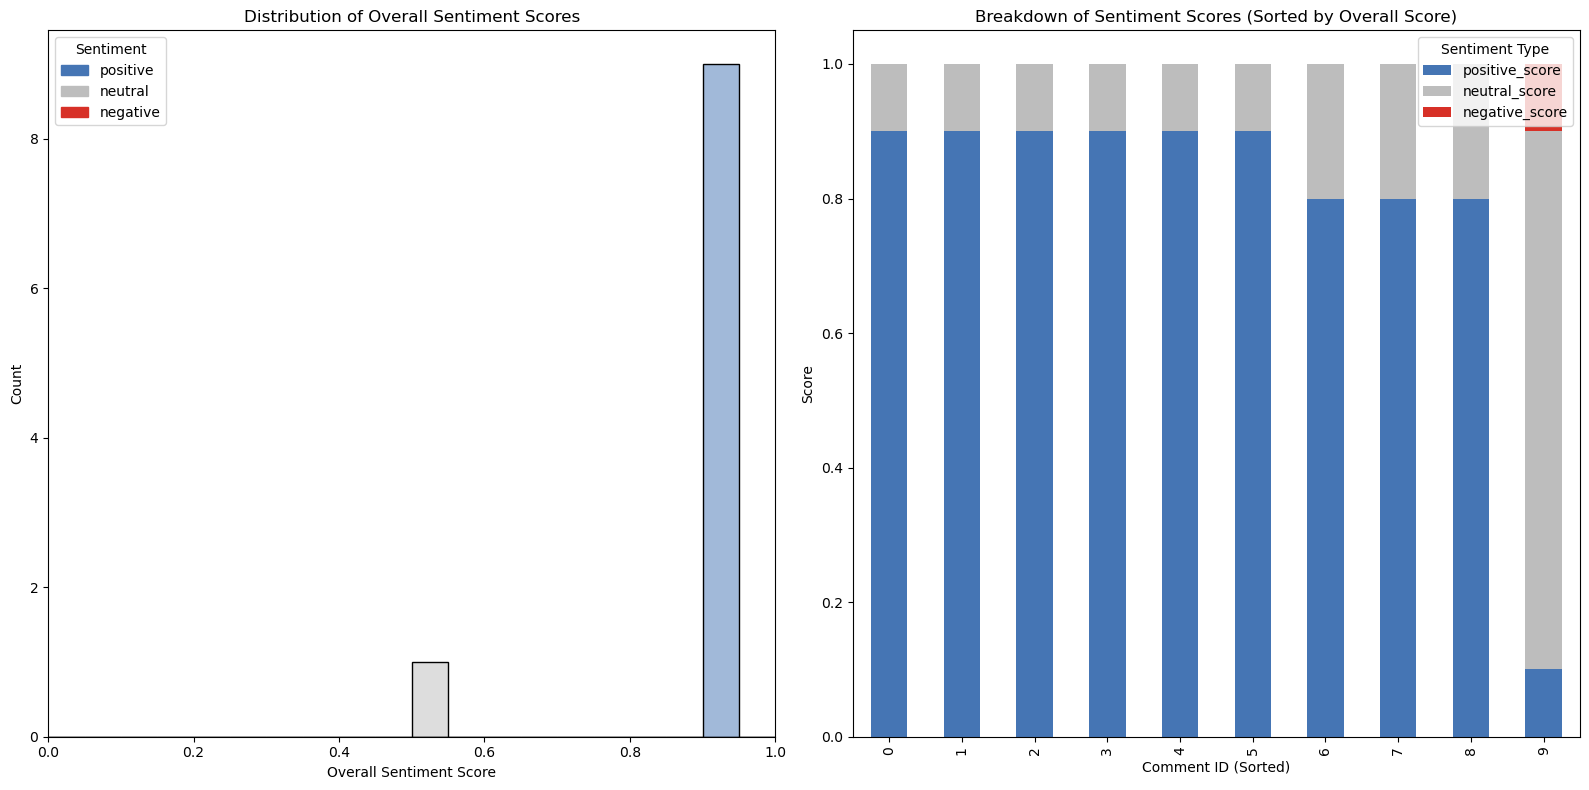

In [150]:
survey_chat()

## Theme derivation

In [179]:
survey_chat()

2024-07-08 19:29:14,797 - feedback_analyzer - INFO - Summarizing comments to find themes
2024-07-08 19:29:26,563 - feedback_analyzer - INFO - Checking and refining themes summary
2024-07-08 19:29:37,512 - feedback_analyzer - INFO - Extracting and citing
